# 1: IMPORTING LIBRARIES AND DATASET

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow import keras
from keras import layers, optimizers
from keras.layers import *
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [2]:
data = pd.read_csv('C:\kaggle\input\lgg-mri-segmentation\kaggle_3m\data.csv')
data.head(10)

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   
5  TCGA_CS_5395            2.0                 4.0             2        2.0   
6  TCGA_CS_5396            3.0                 3.0             2        3.0   
7  TCGA_CS_5397            NaN                 4.0             1        2.0   
8  TCGA_CS_6186            2.0                 4.0             1        2.0   
9  TCGA_CS_6188            2.0                 4.0             3        2.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   
5          NaN              3.0           2                3.0   
6          2.0              2.0           3                3.0   
7          3.0              3.0           2                1.0   
8          1.0              3.0           2                2.0   
9          3.0              3.0           2                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   
5                        1.0                1.0         3.0             5.0   
6                        2.0                1.0         3.0             2.0   
7                        2.0                1.0         1.0             6.0   
8                        2.0                1.0         3.0             2.0   
9                        2.0                1.0         3.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0  
5     2.0                       43.0   2.0        NaN      1.0  
6     1.0                       53.0   3.0        2.0      0.0  
7     1.0                       54.0   3.0        2.0      1.0  
8     2.0                       58.0   3.0        2.0      1.0  
9     2.0                       48.0   3.0        2.0      0.0

In [3]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[WinError 267] The directory name is invalid: '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\data.csv'
[WinError 267] The directory name is invalid: '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\README.md'


In [4]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

patient_id  \
0  kaggle_3m\TCGA_CS_4941_19960909   
1  kaggle_3m\TCGA_CS_4941_19960909   
2  kaggle_3m\TCGA_CS_4941_19960909   
3  kaggle_3m\TCGA_CS_4941_19960909   
4  kaggle_3m\TCGA_CS_4941_19960909   

                                                path  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...

In [5]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = 89
END_IMG_LEN = 4
END_MASK_LEN = 9

imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

idx = random.randint(0, len(imgs)-1)
print("Path per MRI:", imgs[idx], "\nPath per Mask:", masks[idx])

Path per MRI: /kaggle/input/lgg-mri-segmentation/kaggle_3m\TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_17.tif 
Path per Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m\TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_17_mask.tif


In [6]:
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

patient_id  \
0     kaggle_3m\TCGA_CS_4941_19960909   
1     kaggle_3m\TCGA_CS_4941_19960909   
2     kaggle_3m\TCGA_CS_4941_19960909   
3     kaggle_3m\TCGA_CS_4941_19960909   
4     kaggle_3m\TCGA_CS_4941_19960909   
...                               ...   
3924  kaggle_3m\TCGA_HT_A61B_19991127   
3925  kaggle_3m\TCGA_HT_A61B_19991127   
3926  kaggle_3m\TCGA_HT_A61B_19991127   
3927  kaggle_3m\TCGA_HT_A61B_19991127   
3928  kaggle_3m\TCGA_HT_A61B_19991127   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   

                                              mask_path  mask  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...     0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...     0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...     0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...     0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...     0  
...                                                 ...   ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...     0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...     0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...     0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...     0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...     0  

[3929 rows x 4 columns]

# 5: CRETING TEST, TRAIN & VAL SET

In [7]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

In [9]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )

valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )


Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# 6: Trajnojme nje model per klasifikin e imazheve nese nje tumor ekziston ose jo

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50
class_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
class_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [11]:
for layer in class_model.layers:
    layers.trainable = False
# This means that the weights of these layers will not be updated during training, and they will be treated as non-trainable weights1. This is usually done when you want to freeze some layers of a model and only train the rest, for example, in transfer learning scenarios. By freezing the layers, you can preserve the features learned by the model on a previous task and adapt them to a new task with a different dataset2.

In [12]:
# Get the output of the clf_model, which is another model that has been defined before
head = class_model.output
# Add an AveragePooling2D layer to reduce the spatial dimensions of the output
# The pool_size argument specifies the size of the pooling window
head = AveragePooling2D(pool_size=(4,4))(head)
# Add a Flatten layer to reshape the output into a one-dimensional vector
# The name argument specifies the name of the layer
head = Flatten(name='Flatten')(head)
# Add a Dense layer to perform a linear transformation on the output
# The first argument specifies the number of units in the layer
# The activation argument specifies the activation function to use, in this case, relu
head = Dense(256, activation='relu')(head)
# Add a Dropout layer to randomly set some of the output values to zero
# The first argument specifies the fraction of the output values to drop
head = Dropout(0.3)(head)
# Add another Dense layer with relu activation
head = Dense(256, activation='relu')(head)
# Add another Dropout layer with 0.3 dropout rate
head = Dropout(0.3)(head)
# Add a final Dense layer with softmax activation
# The first argument specifies the number of units in the layer, which is 2 in this case
# The softmax activation function outputs a probability distribution over 2 classes
head = Dense(2, activation='softmax')(head)

# Create a new model that takes the input of the clf_model and outputs the head
model = Model(class_model.input, head)
# Compile the model with the specified loss function, optimizer, and metrics
# The loss function measures how well the model predicts the true labels
# The optimizer updates the model's weights based on the loss function
# The metrics are used to evaluate the model's performance, in this case, accuracy
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
# Print a summary of the model's architecture, showing the layer names, output shapes, and number of parameters
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
# Krijo një objekt të klasës EarlyStopping, e cila ndalon trajnimin kur një metrikë e caktuar nuk përmirësohet më
# Argumenti monitor specifikon metrikën për t'u monitoruar, në këtë rast, val_loss, që është humbja në grupin e vlerësimit
# Argumenti mode specifikon nëse metrika duhet të minimizohet ose maksimizohet, në këtë rast, min
# Argumenti verbose specifikon nëse duhet të afishohen mesazhe informative gjatë trajnimit, në këtë rast, 1 do të thotë po
# Argumenti patience specifikon numrin e epokave për të pritur para se të ndalet trajnimi, në këtë rast, 15
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )

# Krijo një objekt të klasës ModelCheckpoint, e cila ruaj peshat e modelit në një skedar kur një metrikë e caktuar arrin një minimum ose maksimum
# Argumenti filepath specifikon emrin e skedarit ku do të ruhen peshat, në këtë rast, clf-resnet-weights.hdf5
# Argumenti verbose specifikon nëse duhet të afishohen mesazhe informative gjatë trajnimit, në këtë rast, 1 do të thotë po
# Argumenti save_best_only specifikon nëse duhet të ruhen vetëm peshat me performancën më të mirë ose jo, në këtë rast, True do të thotë po
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )

# Krijo një objekt të klasës ReduceLROnPlateau, e cila ul ritmin e mësimit kur një metrikë e caktuar nuk përmirësohet më
# Argumenti monitor specifikon metrikën për t'u monitoruar, në këtë rast, val_loss, që është humbja në grupin e vlerësimit
# Argumenti mode specifikon nëse metrika duhet të minimizohet ose maksimizohet, në këtë rast, min
# Argumenti verbose specifikon nëse duhet të afishohen mesazhe informative gjatë trajnimit, në këtë rast, 1 do të thotë po
# Argumenti patience specifikon numrin e epokave për të pritur para se të ulur ritmin e mësimit, në këtë rast, 10
# Argumenti min_delta specifikon ndryshimin minimal qe duhet te ket metrika per te konsideruar si permiresim, ne kete rast 0.0001
# Argumenti factor specifikon faktorin me te cilin do te shumezohet ritmi i mesimit kur te ulur, ne kete rast 0.2
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

# Krijo njё listё me objektet e thirrjeve mbrapa qё do tё pёrdoren gjatё trajnimit tё modelit
callbacks = [checkpointer, earlystopping, reduce_lr]


In [14]:
# Trajno modelin me metodën fit, e cila merr disa argumente si parametra
# Argumenti i parë është train_generator, që është një objekt që gjeneron të dhëna të trajnimit në mënyrë të pafundme
# Argumenti i dytë është steps_per_epoch, që specifikon numrin e hapave që duhet të kryhen në çdo epokë
# Një hap përfshin një grup të dhënash që përdoren për të azhurnuar peshat e modelit
# Numri i hapave për epokë llogaritet duke ndarë numrin e imazheve në train_generator me madhësinë e grupit
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              # Argumenti i tretë është epochs, që specifikon numrin e herave që modeli kalon nëpër të gjitha të dhënat e trajnimit
              epochs = 35, 
              # Argumenti i katërt është validation_data, që është një objekt që gjeneron të dhëna të vlerësimit në mënyrë të pafundme
              # Të dhënat e vlerësimit përdoren për të kontrolluar performancën e modelit në të dhëna të pastra gjatë trajnimit
              validation_data= valid_generator, 
              # Argumenti i pestë është validation_steps, që specifikon numrin e hapave që duhet të kryhen në çdo epokë për vlerësimin
              # Numri i hapave për vleresim llogaritet duke ndar numrin e imazheve ne valid_generator me madhesine e grupit
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              # Argumenti i gjashtё ështё callbacks, qё ështё njё listё me objekte qё thirren gjatё trajnimit për t'u bërё disa veprime
              # Nё kёtё rast, lista pёrfshin checkpointer, earlystopping dhe reduce_lr, qё janё objekte tё krijuara mё parё
              callbacks=[checkpointer, earlystopping])


Epoch 1/35
 51/187 [=======>......................] - ETA: 25s - loss: 1.2985 - accuracy: 0.6679

KeyboardInterrupt: 

In [ ]:
model_json = model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

# Evaluim i modelit 

In [ ]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

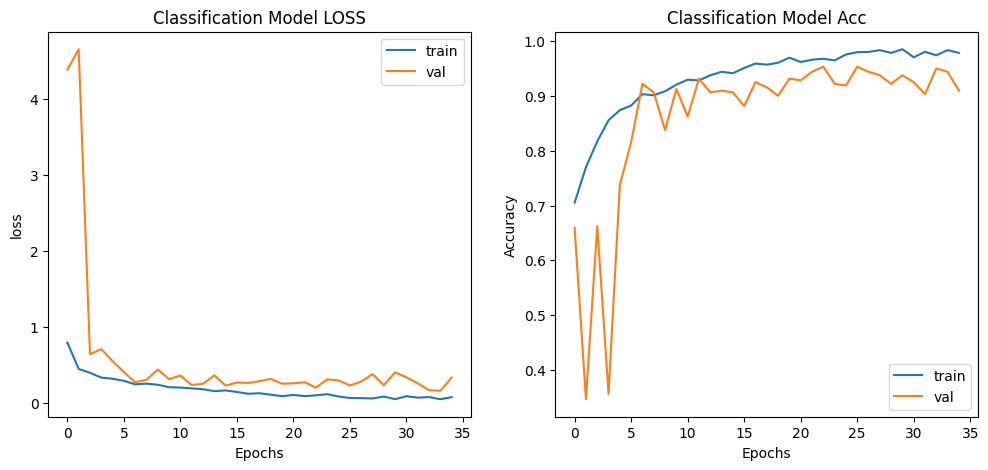

In [ ]:
# Krijo një figurë me madhësinë e caktuar në inç
# Argumenti figsize merr një tuple me gjerësinë dhe gjatësinë e figurës
plt.figure(figsize=(12,5))
# Krijo një subplot në pozicionin e parë të një grile me 1 rresht dhe 2 kolona
# Argumenti i parë specifikon numrin e rreshtave të grilës
# Argumenti i dytë specifikon numrin e kolonave të grilës
# Argumenti i tretë specifikon indeksin e subplotit, duke filluar nga 1
plt.subplot(1,2,1)
# Vizato një grafik me pikat e historikut të humbjes së modelit në grupin e trajnimit dhe vlerësimit
# Argumenti i parë është një listë me vlerat e humbjes në grupin e trajnimit
# Argumenti i dytë është një listë me vlerat e humbjes në grupin e vleresimit
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
# Vendos titullin e subplotit
# Argumenti është një string që përmban titullin
plt.title("Classification Model LOSS");
# Vendos etiketën e boshtit y
# Argumenti është një string që përmban etiketën
plt.ylabel("loss");
# Vendos etiketën e boshtit x
# Argumenti ështё njё string qё pёrmban etiketёn
plt.xlabel("Epochs");
# Vendos legjendën e grafikut
# Argumenti ështё njё listё me emrat e çdo linje tё grafikut
plt.legend(['train', 'val']);

# Krijo njё subplot nё pozicionin e dytё tё njё grile me 1 rresht dhe 2 kolona
plt.subplot(1,2,2)
# Vizato njё grafik me pikat e historikut tё saktёsisё sё modelit nё grupin e trajnimit dhe vlerёsimit
# Argumenti i parё ështё njё listё me vlerat e saktёsisё nё grupin e trajnimit
# Argumenti i dytё ështё njё listё me vlerat e saktёsisё nё grupin e vleresimit
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
# Vendos titullin e subplotit
plt.title("Classification Model Acc");
# Vendos etiketën e boshtit y
plt.ylabel("Accuracy");
# Vendos etiketën e boshtit x
plt.xlabel("Epochs");
# Vendos legjendën e grafikut
plt.legend(['train', 'val']);


In [ ]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 5s 146ms/step - loss: 0.3909 - accuracy: 0.9136
Test accuracy : 91.35593175888062 %


37/37 [==============================] - 4s 76ms/step
0.9135593220338983
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       371
           1       0.84      0.95      0.89       219

    accuracy                           0.91       590
   macro avg       0.90      0.92      0.91       590
weighted avg       0.92      0.91      0.91       590



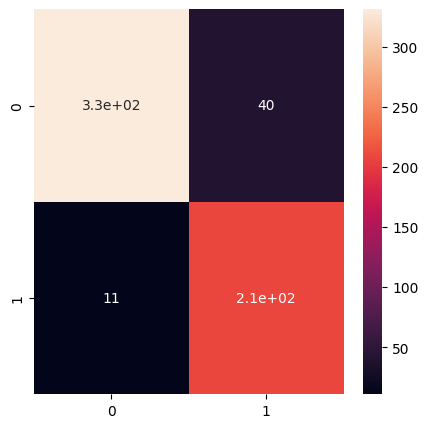

In [ ]:
# Parashiko etiketat e grupit të testimit me metodën predict të modelit
# Argumenti është test_generator, që është një objekt që gjeneron të dhëna të testimit në mënyrë të pafundme
# Metoda kthen një varg me probabilitetet e parashikimit për çdo klasë
prediction = model.predict(test_generator)

# Merr indeksin e maksimumit të probabilitetit për çdo rresht të vargut të parashikimit
# Argumenti axis specifikon boshtin për të gjetur maksimumin, në këtë rast, 1 do të thotë boshti i kolonave
# Kjo kthen një varg me etiketat e parashikuara si 0 ose 1
pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
# Konverto vargun e etiketave origjinale nga test dataframe në një varg të tipit int
original = np.asarray(test['mask']).astype('int')

# Importo disa funksione nga moduli sklearn.metrics, që përdoren për të llogaritur metrika të ndryshme të vlerësimit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Llogarit saktësinë e modelit duke krahasuar etiketat origjinale me ato të parashikuara
# Argumenti i parë është vargu i etiketave origjinale
# Argumenti i dytë është vargu i etiketave të parashikuara
# Funksioni kthen një vlerë nga 0 në 1 që tregon pjesën e etiketave që u parashikuan saktësisht
accuracy = accuracy_score(original, pred)
# Printo vlerën e saktësisë në ekran
print(accuracy)

# Llogarit matricën konfuzioni duke krahasuar etiketat origjinale me ato të parashikuara
# Argumenti i parë është vargu i etiketave origjinale
# Argumenti i dytë është vargu i etiketave të parashikuara
# Funksioni kthen njё matricё ku elementi (i,j) tregon numrin e imazheve qё kanё etiketёn i dhe u parashikuan si j
cm = confusion_matrix(original, pred)

# Llogarit raportin e klasifikimit duke krahasuar etiketat origjinale me ato të parashikuara
# Argumenti i parё ështё vargu i etiketave origjinale
# Argumenti i dytё ështё vargu i etiketave tё parashikuara
# Argumenti labels specifikon listёn e etiketave tё mundshme, nё kёtё rast [0,1]
# Funksioni kthen njё string qё pёrmban metrika tё ndryshme si precizion, rikthim dhe mesatare harmonike pёr secilёn klasё dhe pёr gjithё modelin
report = classification_report(original, pred, labels = [0,1])
# Printo raportin e klasifikimit nё ekran
print(report)
# Krijo njё figurё me madhёsinё e caktuar nё inç
plt.figure(figsize = (5,5))
# Vizato njё grafik tё llojit heatmap me seaborn library 
# Argumenti i parё ështё matrica konfuzioni qё do tё vizatohet
# Argumenti annot specifikon nёse duhet tё shfaqen vlerat e matricёs nё grafik
sns.heatmap(cm, annot=True);


# 8: NDËRTIMI I NJË MODELI SEGMENTIMI PËR LOKALIZIMIN E TUMORIT

In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# Krijo grupe të trajnimit dhe vlerësimit duke përdorur funksionin train_test_split nga moduli sklearn.model_selection
# Argumenti i parë është brain_df_mask, që është një dataframe që përmban shtigjet e imazheve dhe maskave të trurit
# Argumenti i dytë është test_size, që specifikon pjesën e të dhënave që do të rezervohen për grupin e vlerësimit, në këtë rast, 0.15 do të thotë 15%
# Funksioni kthen dy dataframe, X_train dhe X_val, që përmbajnë respektivisht 85% dhe 15% të rreshtave të brain_df_mask
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
# Krijo grupe të testimit dhe vlerësimit duke përdorur sërish funksionin train_test_split
# Argumenti i parë është X_val, që është dataframe i krijuar më parë
# Argumenti i dytë është test_size, që specifikon pjesën e të dhënave që do të rezervohen për grupin e testimit, në këtë rast, 0.5 do të thotë 50%
# Funksioni kthen dy dataframe, X_test dhe X_val, që përmbajnë respektivisht 50% dhe 50% të rreshtave të X_val
X_test, X_val = train_test_split(X_val, test_size=0.5)
# Printo madhësinë e grupeve në ekran duke përdorur metodën format
# Argumenti i parë është një string që përmban tre vende zbritjeje {}
# Argumentet e tjerë janë vlerat që do të vendosen në vendet zbritjeje
# Vlerat janë gjatësitat e dataframe-ve X_train, X_val dhe X_test, që tregojn numrin e rreshtave në secilin dataframe
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

# Krijo njё listё me shtigjet e imazheve tё trajnimit duke pёrdorur metodёn list
# Argumenti ështё kolona image_path e dataframe-it X_train
train_ids = list(X_train.image_path)
# Krijo njё listё me shtigjet e maskave tё trajnimit duke pёrdorur metodёn list
# Argumenti ështё kolona mask_path e dataframe-it X_train
train_mask = list(X_train.mask_path)

# Krijo njё listё me shtigjet e imazheve tё vleresimit duke pёrdorur metodёn list
# Argumenti ështё kolona image_path e dataframe-it X_val
val_ids = list(X_val.image_path)
# Krijo njё listё me shtigjet e maskave tё vleresimit duke pёrdorur metodёn list
# Argumenti ështё kolona mask_path e dataframe-it X_val
val_mask= list(X_val.mask_path)


Train size is 1167, valid size is 103 & test size is 103


In [ ]:
# Klasa DataGenerator që merr si parametra id e imazheve, maskat, direktorine e imazheve, madhësinë e grupit, lartësinë dhe gjerësinë e imazheve dhe një opsion për të përzier indekset
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids # një listë me id e imazheve
    self.mask = mask # një listë me id e maskave
    self.image_dir = image_dir # drejtoria ku ndodhen imazhet
    self.batch_size = batch_size # madhësia e grupit për çdo iteracion
    self.img_h = img_h # lartësia e imazhit në piksel
    self.img_w = img_w # gjerësia e imazhit në piksel
    self.shuffle = shuffle # një vlerë booliane që tregon nëse duhet të përziehen indekset ose jo
    self.on_epoch_end() # thirrja e metodës on_epoch_end për të krijuar një varg me indekset

  def __len__(self):
    'Merr numrin e grupeve për epokë'

    return int(np.floor(len(self.ids)) / self.batch_size) # kthen numrin e plotë të grupeve duke përdorur madhësinë e listës së id dhe madhësinë e grupit

  def __getitem__(self, index):
    'Gjeneron një grup të dhënash'

    #gjeneron një indeks me gjatësi madhësi grupi
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #merr id e imazhit që korrespondojnë me indekset e krijuara më sipër bazuar në madhësinë e grupit
    list_ids = [self.ids[i] for i in indexes]

    #merr id e maskave që korrespondojnë me indekset e krijuara më sipër bazuar në madhësinë e grupit
    list_mask = [self.mask[i] for i in indexes]


    #gjeneron të dhëna për X (karakteristikat) dhe y (etiketën)
    X, y = self.__data_generation(list_ids, list_mask)

    #kthen të dhënat
    return X, y

  def on_epoch_end(self):
    'Përdoret për të azhurnuar indekset pas çdo epoke, një herë në fillim si dhe në fund të çdo epoke'
    
    #merr një varg me indekse bazuar në dataframe hyrje
    self.indexes = np.arange(len(self.ids))

    #nëse shuffle është true, përzie indekset
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'gjeneron të dhënave qe korrespondojn me indekset ne nje grup te dhene te imazheve'

    # krijon vargje bosh me formën (madhësi_grupi,lartesi,gjeresi,thesi) 
    #Thesia ështe 3 për hyrjen dhe thesia merret si 1 për daljen sepse maska ka vetem 1 kanal.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iteron për rreshtat e dataframe-it, të cilat kan gjat si madhesia e grupit
    for i in range(len(list_ids)):
      #shtegu i imazhit
      img_path = str(list_ids[i])
      
      #shtegu i maskes
      mask_path = str(list_mask[i])
      
      #lexon imazhin origjinal dhe masken përkatëse
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #ridimensionon dhe i kthen ato në vargje të tipit float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardizon 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Shton imazhin në vargun bosh
      X[i,] = img
      
      #zgjeron dimensionin e imazhit nga (256,256) në (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizon y
    y = (y > 0).astype(int)

    return X, y

# Krijon dy objekte të klases DataGenerator për të dhënat e trajnimit dhe vlerësimit
train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [ ]:
# Definon një funksion që krijon një bllok rezidual me dy shtresa konvolucione dhe një shteg skip
def resblock(X, f):
    X_copy = X  #kopjon hyrjen
    
    # shtegu kryesor
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X) # aplikon një shtresë konvolucione me madhësi bërthame 1x1 dhe inicializon peshat me një shpërndarje normale
    X = BatchNormalization()(X) # normalizon të dhënat e shtresës
    X = Activation('relu')(X) # aplikon një funksion aktivimi relu
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X) # aplikon një shtresë konvolucione me madhësi bërthame 3x3 dhe inicializon peshat me një shpërndarje normale
    X = BatchNormalization()(X) # normalizon të dhënat e shtresës
    
    # shtegu i shkurtër
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy) # aplikon një shtresë konvolucione me madhësi bërthame 1x1 dhe inicializon peshat me një shpërndarje normale
    X_copy = BatchNormalization()(X_copy) # normalizon të dhënat e shtresës
    
    # Shton rezultatin nga shtegu kryesor dhe shtegu i shkurtër bashkë
    X = Add()([X, X_copy]) # aplikon një funksion që merr dy tensora si hyrje dhe kthen shumën e tyre si dalje
    X = Activation('relu')(X) # aplikon një funksion aktivimi relu
    
    return X # kthen rezultatin si dalje

# Definon një funksion që rrit madhësinë e imazhit dhe bashkon atë me një imazh tjetër
def upsample_concat(x, skip):
    '''
    funksion për rritjen e madhesis se imazhit
    '''
    X = UpSampling2D((2,2))(x) # rrit madhësinë e imazhit me faktorin 2 në çdo dimension
    merge = Concatenate()([X, skip]) # bashkon imazhin e rritur me imazhin tjetër në dimensionin e fundit
    
    return merge # kthen rezultatin si dalje

In [ ]:
# Vendos formën e hyrjes me tri elemente: lartësi, gjerësi dhe channels e imazhit
input_shape = (256,256,3)
# Krijon një tensor të hyrjes me formën e caktuar
X_input = Input(input_shape) 

# Faza 1
# Aplikon një shtresë konvolucione me 16 filtra, madhësi bërthame 3x3, funksion aktivimi relu, mbushje të njëjtë dhe inicializim të peshave me një shpërndarje normale
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
# Normalizon të dhënat e shtresës konvolucione
conv_1 = BatchNormalization()(conv_1)
# Aplikon një shtresë konvolucione tjetër me të njëjtat parametra si më sipër
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
# Normalizon të dhënat e shtresës konvolucione
conv_1 = BatchNormalization()(conv_1)
# Aplikon një shtresë max pooling me madhësi hap 2x2 për të zvogluar dimensionin e imazhit
pool_1 = MaxPool2D((2,2))(conv_1)

# Faza 2
# Aplikon një bllok rezidual me 32 filtra duke përdorur funksionin resblock që është definuar më parë
conv_2 = resblock(pool_1, 32)
# Aplikon një shtresë max pooling me madhësi hap 2x2 për të zvogluar dimensionin e imazhit
pool_2 = MaxPool2D((2,2))(conv_2)

# Faza 3
# Aplikon një bllok rezidual me 64 filtra duke përdorur funksionin resblock që është definuar më parë
conv_3 = resblock(pool_2, 64)
# Aplikon një shtresë max pooling me madhësi hap 2x2 për të zvogluar dimensionin e imazhit
pool_3 = MaxPool2D((2,2))(conv_3)

# Faza 4
# Aplikon një bllok rezidual me 128 filtra duke përdorur funksionin resblock qe ështé definuar mè parè
conv_4 = resblock(pool_3, 128)
# Aplikon njé shtresé max pooling me madhési hap 2x2 për té zvogluar dimensionin e imazhit
pool_4 = MaxPool2D((2,2))(conv_4)

# Faza 5 (fytja)
# Aplikon njé bllok rezidual me 256 filtra duke pèrdorur funksionin resblock qè ështè definuar mè parè
conv_5 = resblock(pool_4, 256)

# Faza e rritjes sè madhésisè 1
# Rrit madhésinè e imazhit dhe e bashkon atè me rezultatin e fazès 4 duke pèrdorur funksionin upsample_concat qè ështè definuar mè parè
up_1 = upsample_concat(conv_5, conv_4)
# Aplikon njé bllok rezidual me 128 filtra duke pèrdorur funksionin resblock qè ështè definuar mè parè
up_1 = resblock(up_1, 128)

# Faza e rritjes sè madhésisè 2
# Rrit madhésinè e imazhit dhe e bashkon atè me rezultatin e fazès 3 duke pèrdorur funksionin upsample_concat qè ështè definuar mè parè
up_2 = upsample_concat(up_1, conv_3)
# Aplikon njé bllok rezidual me 64 filtra duke pèrdorur funksionin resblock qè ështè definuar mè parè
up_2 = resblock(up_2, 64)

# Faza e rritjes sè madhésisè 3
# Rrit madhésinè e imazhit dhe e bashkon atè me rezultatin e fazès 2 duke pèrdorur funksionin upsample_concat qè ështè definuar mè parè
up_3 = upsample_concat(up_2, conv_2)
# Aplikon njé bllok rezidual me 32 filtra duke pèrdorur funksionin resblock qè ështè definuar mè parè
up_3 = resblock(up_3, 32)

# Faza e rritjes sè madhésisè 4
# Rrit madhésinè e imazhit dhe e bashkon atè me rezultatin e fazès 1 duke pèrdorur funksionin upsample_concat qè ështè definuar mè parè
up_4 = upsample_concat(up_3, conv_1)
# Aplikon njé bllok rezidual me 16 filtra duke përdorur funksionin resblock që është definuar më parë
up_4 = resblock(up_4, 16)

# dalja finale
# Aplikon një shtresë konvolucione me 1 filtr, madhësi bërthame 1x1, inicializim të peshave me një shpërndarje normale, mbushje të njëjtë dhe funksion aktivimi sigmoid
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

# Krijon një model të segmentimit të imazhit duke përdorur tensorin e hyrjes dhe daljes
seg_model = Model(X_input, out)
# Shfaq përmbledhjen e modelit
seg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

# 9: TRAINING SEGMENTATION MODEL

In [ ]:
# Define a custom loss function for ResUNet model
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

c:\Users\Gigabyte\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


NameError: name 'seg_model' is not defined

In [ ]:
h = seg_model.fit(train_data, 
                  epochs = 35, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/35
72/72 [==============================] - ETA: 0s - loss: 0.7988 - tversky: 0.2567
Epoch 1: val_loss improved from inf to 0.88163, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 17s 189ms/step - loss: 0.7988 - tversky: 0.2567 - val_loss: 0.8816 - val_tversky: 0.1543 - lr: 0.0500
Epoch 2/35
72/72 [==============================] - ETA: 0s - loss: 0.4747 - tversky: 0.6263
Epoch 2: val_loss improved from 0.88163 to 0.53691, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 13s 177ms/step - loss: 0.4747 - tversky: 0.6263 - val_loss: 0.5369 - val_tversky: 0.5626 - lr: 0.0500
Epoch 3/35
72/72 [==============================] - ETA: 0s - loss: 0.4015 - tversky: 0.7014
Epoch 3: val_loss did not improve from 0.53691
72/72 [==============================] - 13s 173ms/step - loss: 0.4015 - tversky: 0.7014 - val_loss: 0.5636 - val_tversky: 0.5329 - lr: 0.0500
Epoch 4/35
72/72 [==============================] - E

In [ ]:
# saving model achitecture in json file
seg_model_json = seg_model.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

NameError: name 'seg_model' is not defined

# 10: SEGMENTATION MODEL EVALUATION

In [ ]:
h.history.keys()

NameError: name 'h' is not defined

NameError: name 'h' is not defined

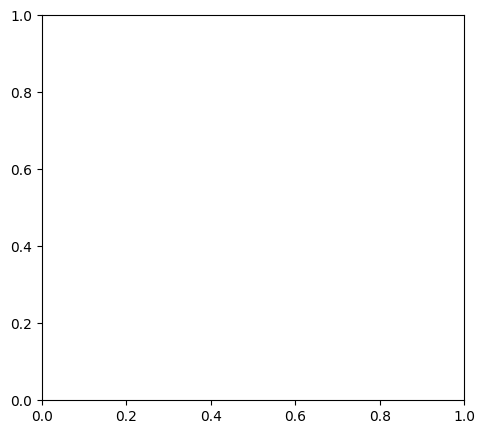

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 1s 93ms/step - loss: 0.1717 - tversky: 0.9043
Segmentation tversky is 90.43%


# 11: SEGMENTATION MODEL PREFORMACE 
## (COMBINING CLASSIFICATION AND SEGMENTAION MODEL BUILDING PIPELINE)

In [ ]:
# Definon një funksion të parashikimit që merr një dataframe që përmban ImageID si hyrje dhe bën dy lloj të parashikimit mbi imazhin
def prediction(test, model, model_seg):
    '''
    Funksioni i parashikimit qe merr njé dataframe qé përmban ImageID si hyrje dhe bén 2 lloj te parashikimit mbi imazhin
    Fillimisht, imazhi kalon nëpër rrjetin e klasifikimit që parashikon nëse imazhi ka defekt apo jo, nëse modeli
    ështé 99% i sigurt që imazhi nuk ka defekt, atëherë imazhi etiketohet si pa-defekt, nëse modeli nuk është i sigurt, ai kalon imazhin tek
    rrjeti i segmentimit, ai kontrollon përsëri nëse imazhi ka defekt apo jo, nëse ka defekt, atëherë lloji dhe vendndodhja e defektit gjendet
    '''
    # listë bosh për të ruajtur rezultatet
    mask, image_id, has_mask = [], [], []
    
    #iteron nëpër çdo imazh në të dhënat e testit
    for i in test.image_path:
        
        img = io.imread(i) # lexon imazhin nga shtegu i dhënë
        #normalizon
        img = img *1./255. # shumëzon imazhin me 1/255 për të kthyer vlerat e pikselave në intervalin [0,1]
        #ridimensionon
        img = cv2.resize(img, (256,256)) # ndryshon madhësinë e imazhit në 256x256 piksel
        # e kthen img në varg
        img = np.array(img, dtype=np.float64) # kthen imazhin në një varg numpy me tip të dhënash float64
        #ndryshon formën e imazhit nga 256,256,3 në 1,256,256,3
        img = np.reshape(img, (1,256,256,3)) # ndryshon formën e vargut për të pasur një dimension shtesë për numrin e mostrave
        
        #bën parashikimin për tumorin në imazh
        is_defect = model.predict(img) # përdor modelin e klasifikimit për të parashikuar nëse imazhi ka defekt apo jo
        
        #nëse tumor nuk ështé i pranishém ne shtojmé detajet e imazhit ne listé
        if np.argmax(is_defect)==0: # kontrollon nëse vlera maksimale e parashikimit është për klasën 0 (pa defekt)
            image_id.append(i) # shton shtegun e imazhit në listën image_id
            has_mask.append(0) # shton vlerën 0 në listën has_mask për të treguar se nuk ka maskë
            mask.append('No mask :)') # shton një mesazh 'No mask :)' në listën mask për të treguar se nuk ka defekt
            continue # kalon tek iteracioni tjetër
        
        #Krijon njé varg bosh me formé 1,256,256,3
        X = np.empty((1,256,256,3)) # krijon një varg numpy bosh me formën e caktuar
        # lexon imazhin
        img = io.imread(i) # lexon imazhin nga shtegu i dhënë
        #ridimensionon imazhin dhe i kthen ato ne varg te tipit float64
        img = cv2.resize(img, (256,256)) # ndryshon madhësinë e imazhit në 256x256 piksel
        img = np.array(img, dtype=np.float64) # kthen imazhin në një varg numpy me tip të dhënash float64
        
        # standardizon imazhin
        img -= img.mean() # zbrit vlerën mesatare të imazhit nga çdo piksel
        img /= img.std() # ndaj devijimin standard të imazhit me çdo piksel
        #ndryshon formén e imazhit nga 256,256,3 në 1,256,256,3
        X[0,] = img # vendos imazhin në vargun X
        
        #bën parashikimin e maskës
        predict = model_seg.predict(X) # përdor modelin e segmentimit për të parashikuar maskën e defektit
        
        # nëse shuma e maskës së parashikuar është 0 atëherë nuk ka tumor
        if predict.round().astype(int).sum()==0: # kontrollon nëse shuma e vlerave të maskës së rrumbullakosur në numra të plotë është zero
            image_id.append(i) # shton shtegun e imazhit në listën image_id
            has_mask.append(0) # shton vlerën 0 në listën has_mask për të treguar se nuk ka maskë
            mask.append('No mask :)') # shton një mesazh 'No mask :)' në listën mask për të treguar se nuk ka defekt
        else:
        #nëse shuma e vlerave të pikselave është më shumë se 0, atëherë ka tumor
            image_id.append(i) # shton shtegun e imazhit në listën image_id
            has_mask.append(1) # shton vlerën 1 në listën has_mask për të treguar se ka maskë
            mask.append(predict) # shton maskën e parashikuar në listën mask
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask}) # kthen një dataframe me kolonat image_path, predicted_mask dhe has_mask

In [ ]:
# making prediction
df_pred = prediction(test, model, seg_model)
df_pred

1/1 [==============================] - 0s 21ms/step


image_path  \
0    /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
1    /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
2    /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
3    /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
4    /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
..                                                 ...   
585  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
586  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
587  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
588  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   
589  /kaggle/input/lgg-mri-segmentation/kaggle_3m\T...   

                                        predicted_mask  has_mask  
0                                           No mask :)         0  
1                                           No mask :)         0  
2                                           No mask :)         0  
3                                           No mask :)         0  
4    [[[[8.601945e-07], [2.500724e-07], [4.9479814e...         1  
..                                                 ...       ...  
585                                         No mask :)         0  
586  [[[[9.745374e-07], [9.946706e-07], [2.0753996e...         1  
587                                         No mask :)         0  
588  [[[[1.3732327e-06], [1.7580045e-06], [3.235567...         1  
589                                         No mask :)         0  

[590 rows x 3 columns]

In [ ]:
# merging original and prediction df
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

NameError: name 'df_pred' is not defined

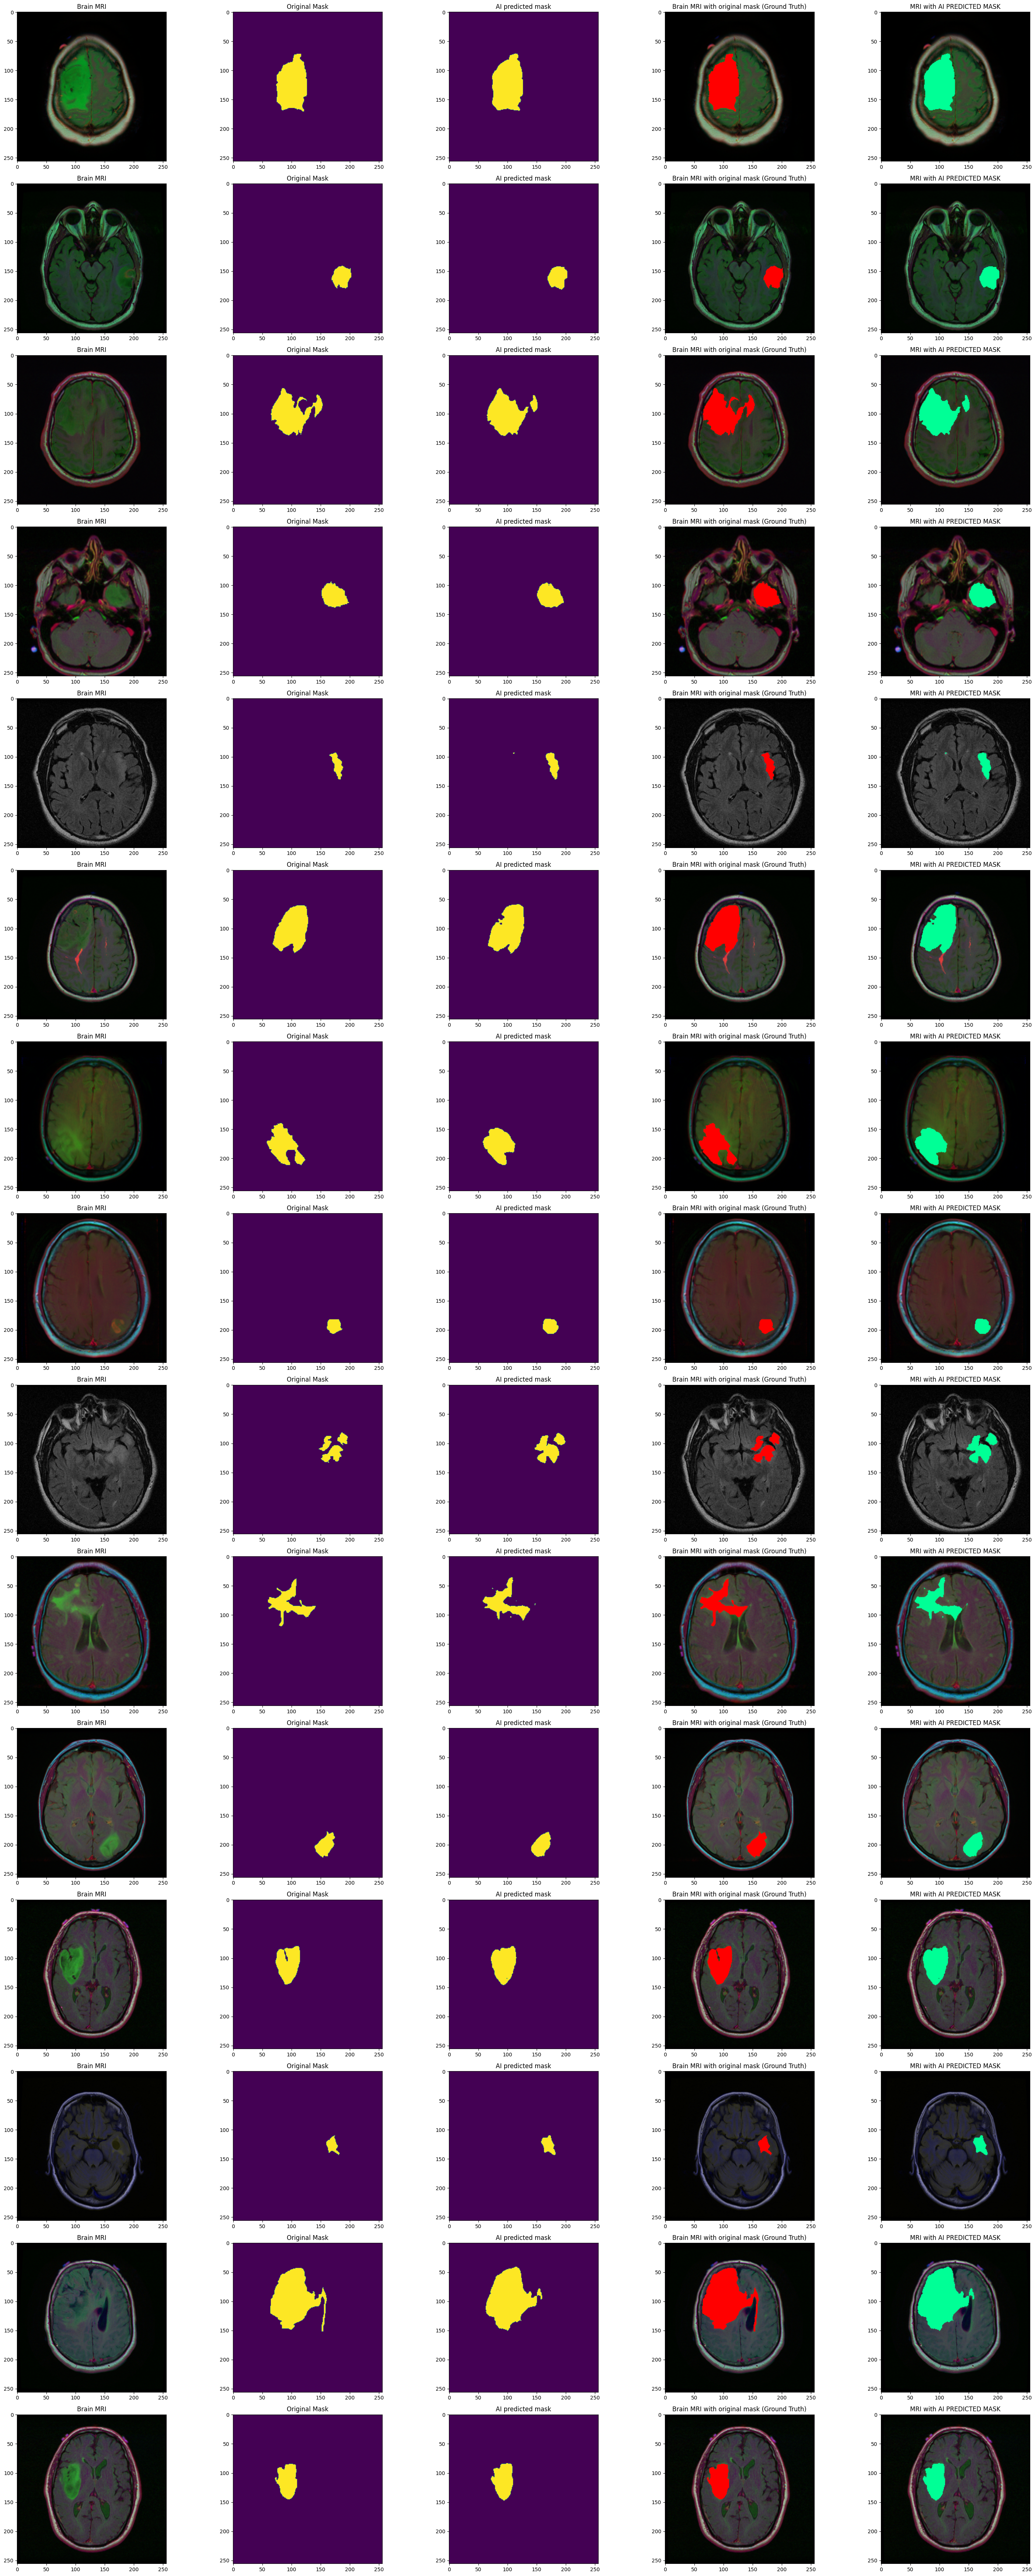

In [ ]:
#visualizing prediction
count = 0 #initialize a counter variable
fig, axs = plt.subplots(15,5, figsize=(30,70)) #krijojme nje figure me 15 rreshta dhe 5 kolona ku cdo imazh esht 30 me 70 pixela

for i in range(len(df_pred)): #loop ne rreshtat e dataframe df_pred, qe ka the image paths, mask paths, dhe predicted masks
    if df_pred.has_mask[i]==1 and count<15: #shiko nese rreshti ka maske dhe counter eshte me pak se 15
        #imazhet e mri
        img = io.imread(df_pred.image_path[i]) #lexo imazhin
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert nga BGR (blue-green-red) ne RGB (red-green-blue)
        axs[count][0].imshow(img) #bejme plot imazhin
        axs[count][0].title.set_text('Brain MRI') #vendosim titullin 'Brain MRI'
        
        #imazhet e maskes origjinale
        mask = io.imread(df_pred.mask_path[i]) #lexojme masken
        axs[count][1].imshow(mask) #bejme plot masken
        axs[count][1].title.set_text('Original Mask') #vendosim titullin 'Original Mask'
        
        #imazhet e maskes se krijuar
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round() #convert the predicted mask from a list to a numpy array, remove any singleton dimensions using squeeze, and round the values to 0 or 1 using round
        axs[count][2].imshow(pred) #plot the predicted mask on the third subplot of the current row
        axs[count][2].title.set_text('AI predicted mask') #set the title of the subplot as 'AI predicted mask'
        
        #bejme overlay masken origjinale me mri
        img[mask==255] = (255,0,0) #ndryshojme pixelat ku kemi kancer ne ngjyre te kuqe
        axs[count][3].imshow(img) #bejme plot imazhin
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)') #vendosim titullin 'Brain MRI with original mask (Ground Truth)'
        
        #bejme overlay masken e krijuar me mri
        img_ = io.imread(df_pred.image_path[i]) #lexojme imazhin
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB) #convert nga BGR (blue-green-red) ne RGB (red-green-blue)
        img_[pred==1] = (0,255,150) #ndryshojme pixelat ku kemi gjetur qeliza kanceri ne ngjyre jeshile
        axs[count][4].imshow(img_) #bejme plot immazhin
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK') #vendosim titullin 'MRI with AI PREDICTED MASK'
        
        count +=1 #rrisim counter
    if (count==15): #shohim nese counter ka arritur 15
        break #stop loop

fig.tight_layout() #rregullojme layout te imazheve ne menyre qe mos te kemi mbivendosje
